# GPLVM with count observations

Gaussian process latent variable model

### Table of contents

1. [**Synthetic place cell population**](#synthetic)
1. [**Fit GPLVM model**](#fit)
3. [**Evaluate latent space**](#latent)
4. [**Evaluate tuning curve**](#tuning)


In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

import numpy as np


import sys
sys.path.append("..")

import neuroprob as nprb
from neuroprob import utils


dev = nprb.inference.get_device()

PyTorch version: 1.13.0+cu117
Using device: cuda:0


In [2]:
# plotting functions
def raster_plot(
    figax, spikes, time_bins, bin_time, units, colors=None, marker="|", markersize=2
):
    """
    Visualize a 2D array representing point events, spikes has shape (timstep, units).

    :param list colors: colors to be included in the colormap
    :param string name: name the colormap
    :returns: figure and axis
    :rtype: tuple
    """
    fig, ax = figax
    if colors is None:
        col = ["k"] * units
    else:
        col = colors
    for i in range(units):
        t = np.nonzero(spikes[i, :])[0] * bin_time
        ax.scatter(t, (i + 1) * np.ones_like(t), c=col[i], s=markersize, marker=marker)

    ax.set_xlim(0, time_bins * bin_time)
    ax.set_ylim(0.1, units + 0.9)
    ax.set_yticks(np.arange(1, units + 1))
    

<a id="synthetic"></a>
## 1. Poisson Gaussian place field synthetic data

In [3]:
# animal position
def rbf_kernel(x):
    return np.exp(-.5 * (x**2))


def stationary_GP_trajectories(Tl, dt, tau_list, eps, kernel_func, jitter=1e-9):
    """
    generate smooth GP input
    """
    out_dims = len(tau_list)
    
    l = np.array(tau_list)[:, None]
    v = np.ones(out_dims)

    T = np.arange(Tl)[None, :]*dt / l
    dT = T[:, None, :] - T[..., None] # (out, T, T)
    K = kernel_func(dT)
    K.reshape(out_dims, -1)[:, ::Tl+1] += jitter
    
    L = np.linalg.cholesky(K)
    v = (L @ eps[..., None])[..., 0]
    a_t = v.reshape(trials, -1, Tl)
    return a_t # trials, tau_arr, time



def quadratic_2D_GLM(x, w, nonlin=np.exp):
    """
    Quadratic GLM for position
    
    :param np.array x: input series of shape (2,)
    :param np.array w: weights of shape (neurons, 6)
    :return:
        rate array of shape (trials, time, neurons)
    """
    x, y = x[..., 0], x[..., 1]
    g = np.stack((np.ones_like(x), x, y, x**2, y**2, x*y), axis=-1)
    return nonlin((g[..., None, :]*w).sum(-1))



def gaussian_2D_to_w(mu, prec, rate_0):
    """
    Get GLM parameters from Gaussian and orthogonal theta parameterization
    
    :param np.array mu: mean of the Gaussian field of shape (neurons, 2)
    :param np.array prec: precision matrix elements xx, yy, and xy of shape (neurons, 3)
    :param np.array rate_0: rate amplitude of shape (neurons)
    
    """
    neurons = mu.shape[0]
    prec_mat = []
    for n in range(neurons):
        prec_mat.append([[prec[n, 0], prec[n, 2]], [prec[n, 2], prec[n, 1]]])
    prec_mat = np.array(prec_mat)
    w = np.empty((neurons, 6))
    w[:, 0] = np.log(rate_0) - 0.5*(mu * np.einsum('nij,nj->ni', prec_mat, mu)).sum(1)
    w[:, 1] = mu[:, 0]*prec[:, 0] + mu[:, 1]*prec[:, 2]
    w[:, 2] = mu[:, 1]*prec[:, 1] + mu[:, 0]*prec[:, 2]
    w[:, 3] = -0.5*prec[:, 0]
    w[:, 4] = -0.5*prec[:, 1]
    w[:, 5] = -prec[:, 2]
    return w

In [4]:
# animal pos
dt = 0.03  # s
Tl = 2500
out_dims = 2
trials = 1
tau_list = [5.0, 5.0]

# seed
rng = np.random.default_rng(123)

eps = rng.normal(size=(trials, out_dims, Tl))
an_pos = stationary_GP_trajectories(Tl, dt, tau_list, eps, rbf_kernel)

an_pos = an_pos.transpose(0, 2, 1)

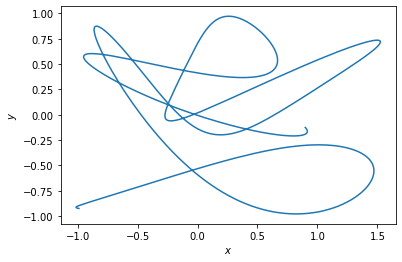

In [9]:
plt.figure()
plt.plot(an_pos[0, :, 0], an_pos[0, :, 1])
plt.ylabel(r'$y$')
plt.xlabel(r'$x$')
plt.show()

In [10]:
N_x = 6
N_y = 6

mu, prec, rate_0 = [], [], []
for nx in range(N_x):
    for ny in range(N_y):
        mu.append([nx * 6 / (N_x - 1) - 3., ny * 6 / (N_y - 1) - 3.])
        prec.append([1., 1., 0.0])
        rate_0.append(20.)  # Hz
        
mu, prec, rate_0 = np.array(mu), np.array(prec), np.array(rate_0)
w = gaussian_2D_to_w(mu, prec, rate_0)

neurons = rate_0.shape[0]

rates_t = quadratic_2D_GLM(an_pos, w, np.exp)
rates_t = rates_t.transpose(0, 2, 1)

In [11]:
cc = np.meshgrid(np.linspace(-3., 3., 30), np.linspace(-3., 3., 30))
pos_grid = np.stack(cc, axis=-1)

maps = quadratic_2D_GLM(pos_grid, w, np.exp)

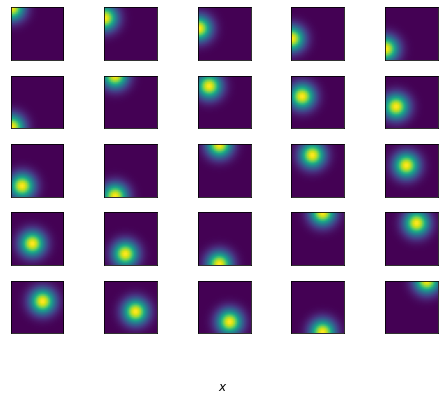

In [12]:
# show fits
grid_size = (50, 40)
grid_shape = [[-3., 3.], [-3., 3.]]

show_neurons = np.arange(25)

fig = plt.figure(figsize=(8, 6), facecolor='white')
nrows = 5
ncols = 5
axes = [ fig.add_subplot(nrows, ncols, r * ncols + c + 1) for r in range(0, nrows) for c in range(0, ncols) ]

for m, neuron in enumerate(show_neurons):

    if neuron == 4:
        #cbar = True
        ticktitle='Firing rate (Hz)'
    else:
        #cbar = False
        ticktitle=''
        
    im = axes[m].imshow(maps[..., m])
    if m == 0:
        ylabel=r'$y$'
    else:
        ylabel=None
        
    axes[m].set_xticks([])
    axes[m].set_yticks([])

fig.text(0.51, 0.0, r'$x$', ha='center', va='center', fontsize=12)

fig.subplots_adjust(hspace=0.3, wspace=0.3)


plt.show()

In [14]:
# generate spike counts
cnts = rng.poisson(rates_t*dt)

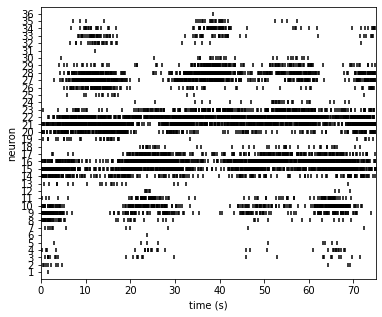

In [22]:
tr = 0

fig, ax = plt.subplots(figsize=(6,5))
raster_plot((fig, ax), cnts[tr], Tl, dt, neurons, markersize=10)
ax.set_xlabel('time (s)')
ax.set_ylabel('neuron')
plt.show()

<a id="fit"></a>
## 2. Fit GPLVM model

$R^2$ latent space.

In [23]:
def align_CCA(X, X_tar):
    """
    :param np.array X: input variables of shape (time, dimensions)
    """
    d = X.shape[-1]
    cca = CCA(n_components=d)
    cca.fit(X, X_tar)
    X_c = cca.transform(X)
    return X_c, cca

In [24]:
# latent GP prior
base_d = 2


# kernel
l = 5.*torch.ones(1, base_d)
v = torch.ones(base_d)

krn_1 = nprb.kernels.Constant(variance=v, tensor_type=torch.float)
krn_2 = nprb.kernels.Exponential(
    input_dims=l.shape[0], lengthscale=l, \
    track_dims=[0], f='softplus', \
    tensor_type=torch.float
)

kernel = nprb.kernels.Product(krn_1, krn_2)

# inducing points
num_induc = 64
inducing_points = np.array(
    [np.linspace(0, Tl*dt, num_induc)]).T[None, ...].repeat(base_d, axis=0)

Xu = np.array(
    [np.linspace(0, 2*np.pi, num_induc+1)[:-1]]
).T[None, ...].repeat(base_d, axis=0)
inducing_points = nprb.mappings.inducing_points(base_d, torch.from_numpy(Xu))

# mapping
in_dims = Xu.shape[-1]
latent_gp = nprb.mappings.SVGP(
    in_dims, base_d, kernel, inducing_points=inducing_points, 
    whiten=True, jitter=1e-4, mean=torch.zeros(base_d), learn_mean=True
)

# inputs
input_data = [torch.arange(Tl)*dt]
input_group = nprb.inputs.input_group()
input_group.set_XZ(input_data, Tl, batch_info=500, trials=trials)


### assemble ###
gp_prior = nprb.inputs.probabilistic_mapping(input_group, latent_gp)

In [26]:
# kernel
l = 5.*torch.ones(1, neurons)
v = torch.ones(neurons)

krn_1 = nprb.kernels.Constant(variance=v, tensor_type=torch.float)
krn_2 = nprb.kernels.SquaredExponential(
    input_dims=len(l), lengthscale=l, \
    track_dims=[0], topology='ring', f='softplus', \
    tensor_type=torch.float
)

kernel = nprb.kernels.Product(krn_1, krn_2)

# inducing points
num_induc = 8
Xu = np.array(
    [np.linspace(0, 2*np.pi, num_induc+1)[:-1]]
).T[None, ...].repeat(neurons, axis=0)
inducing_points = nprb.mappings.inducing_points(neurons, torch.from_numpy(Xu))

# inputs
input_data = [gp_prior]
input_group = nprb.inputs.input_group()
input_group.set_XZ(input_data, Tl, batch_info=500, trials=trials)

# mapping
in_dims = Xu.shape[-1]
gp = nprb.mappings.SVGP(
    in_dims, neurons, kernel, inducing_points=inducing_points, 
    whiten=True, jitter=1e-4, mean=torch.zeros(neurons), learn_mean=True
)


#likelihood = mdl.likelihoods.Gaussian(neurons, 'exp', log_var=np.zeros(neurons))
likelihood = nprb.likelihoods.discrete.Poisson(dt, neurons, 'exp')
#likelihood = mdl.likelihoods.ZI_Poisson(tbin, neurons, 'exp', 0.0*np.zeros(neurons))
likelihood.set_Y(torch.from_numpy(cnts), batch_info=500) 


# assemble
gplvm = nprb.inference.VI_optimized(input_group, gp, likelihood)
gplvm.to(dev)

VI_optimized(
  (input_group): input_group(
    (input_0): probabilistic_mapping(
      (mapping): SVGP(
        (kernel): Product(
          (kern0): Constant()
          (kern1): Exponential()
        )
        (induc_pts): inducing_points()
      )
      (input_group): input_group()
    )
  )
  (mapping): SVGP(
    (kernel): Product(
      (kern0): Constant()
      (kern1): SquaredExponential()
    )
    (induc_pts): inducing_points()
  )
  (likelihood): Poisson()
)

In [27]:
# fitting
sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.9)
opt_tuple = (optim.Adam, 100, sch)
opt_lr_dict = {
    'default': 5*1e-3, 
    #'inputs.lv_std_0': 1e-3,  
}

gplvm.set_optimizers(opt_tuple, opt_lr_dict)

annealing = lambda x: 1.0#min(1.0, 0.005*x)
losses = gplvm.fit(
    3000, loss_margin=0.0, margin_epochs=100, kl_anneal_func=annealing, 
    cov_samples=1, ll_samples=10, ll_mode='MC', 
)

  0%|          | 0/3000 [00:00<?, ?it/s]

ValueError: Expected parameter scale_tril (Tensor of shape (2, 64, 64)) of distribution MultivariateNormal(loc: torch.Size([2, 64]), scale_tril: torch.Size([2, 64, 64])) to satisfy the constraint LowerCholesky(), but found invalid values:
tensor([[[1.0037, 0.0037, 0.0037,  ..., 0.0037, 0.0037, 0.0037],
         [0.0037, 1.0037, 0.0037,  ..., 0.0037, 0.0037, 0.0037],
         [0.0037, 0.0037, 1.0037,  ..., 0.0037, 0.0037, 0.0037],
         ...,
         [0.0037, 0.0037, 0.0037,  ..., 1.0037, 0.0037, 0.0037],
         [0.0037, 0.0037, 0.0037,  ..., 0.0037, 1.0037, 0.0037],
         [0.0037, 0.0037, 0.0037,  ..., 0.0037, 0.0037, 1.0037]],

        [[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 1.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000]]],
       device='cuda:0', grad_fn=<ExpandBackward0>)

<a id='latent'></a>
## 3. Evaluate latent space

27549.04887005676
15123.524000091631
15041.686962485448
27374.826455378803


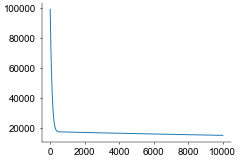

In [12]:
X_loc, X_std = gplvm.inputs.eval_XZ()
Xsig = X_loc[0].T
Xstd = X_std[0].T

rcov = np.concatenate((rx_t[None], ry_t[None]), axis=0)
scales_arr = [torch.tensor([rx_t.std()*2, ry_t.std()*2], device=dev), 
              torch.tensor([-rx_t.std()*2, ry_t.std()*2], device=dev), 
              torch.tensor([rx_t.std()*2, -ry_t.std()*2], device=dev), 
              torch.tensor([-rx_t.std()*2, -ry_t.std()*2], device=dev)]# take into account reflections

W_, bias_, scale_, losses_ = utils.latent.align_affine_2D(Xsig, rcov, scales_arr, dev=dev, iters=10000, lr=5*1e-3)
plt.plot(losses_[:])
plt.show()

aligned_loc = scale_[:, None]*(W_ @ Xsig + bias_[:, None])
aligned_std = np.sqrt(scale_[:, None]**2 *((W_**2).T @ Xstd**2))

In [13]:
covariates = np.arange(resamples)*tbin
#mean = gp_base_2.eval_rate(covariates[None, :], [0], n_samp=10000)[0]
lat_mean, lat_var = gp_base.compute_F(torch.tensor(covariates[None, :, None]).float().to(dev))
#lat_mean2, lat_var2 = gp_base_2(torch.tensor(covariates[None, :, None]).float().to(dev))

lat_mean = lat_mean.data.cpu().numpy()[0]
lat_dvar = lat_var.data.cpu().numpy()[0]

post_mean = scale_[:, None]*(W_ @ lat_mean + bias_[:, None])
post_std = np.sqrt(scale_[:, None]**2 *((W_**2).T @ lat_dvar))

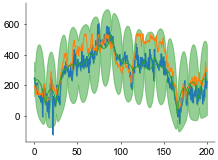

In [14]:
TT = 500

ax = plt.gca()
tx = np.arange(TT)*tbin

line, = ax.plot(tx, aligned_loc[0][:TT])
ax.fill_between(
    tx, aligned_loc[0][:TT]-aligned_std[0][:TT],
    aligned_loc[0][:TT]+aligned_std[0][:TT], color=line.get_color(), alpha=0.5
)

ax.plot(tx, rx_t[:TT])

line, = ax.plot(tx, post_mean[0][:TT])
ax.fill_between(
    tx, post_mean[0][:TT]-post_std[0][:TT],
    post_mean[0][:TT]+post_std[0][:TT], color=line.get_color(), alpha=0.5
)

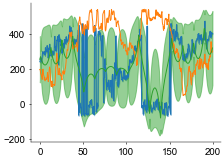

In [15]:
TT = 500

ax = plt.gca()
tx = np.arange(TT)*tbin

line, = ax.plot(tx, aligned_loc[1][:TT])
ax.fill_between(
    tx, aligned_loc[1][:TT]-aligned_std[1][:TT],
    aligned_loc[1][:TT]+aligned_std[1][:TT], color=line.get_color(), alpha=0.5
)

ax.plot(tx, rx_t[:TT])

line, = ax.plot(tx, post_mean[1][:TT])
ax.fill_between(
    tx, post_mean[1][:TT]-post_std[1][:TT],
    post_mean[1][:TT]+post_std[1][:TT], color=line.get_color(), alpha=0.5
)

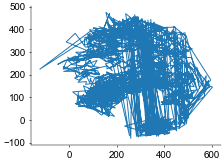

In [16]:
plt.plot(aligned_loc[0], aligned_loc[1])

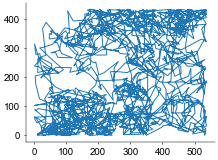

In [17]:
plt.plot(rx_t, ry_t)

In [ ]:
print(gplvm.mapping.kernel.kern0.variance.data.cpu().numpy())
print(gplvm.mapping.kernel.kern1.lengthscale.data.cpu().numpy())

<a id='tuning'></a>
## 4. Evaluate tuning curves

In [20]:
grid_size = (50, 40)
grid_shape = [[left_x, right_x], [bottom_y, top_y]]

show_neurons = np.arange(units_used)

def func(pos):
    prevshape = pos.shape[1:]
    x = pos[0].flatten()
    y = pos[1].flatten()
    covariates = np.array([x, y])
    covariates = np.linalg.inv(W_) @ (covariates/scale_[:, None] - bias_[:, None])
    return gp_lvm.eval_rate(covariates, show_neurons).reshape(units_used, *prevshape)

_, field_fit = utils.plot.compute_mesh(grid_size, grid_shape, func)

In [45]:
# True tuning, grid of place fields
N_x = 5
N_y = 5
x_ = np.repeat(np.linspace(left_x, right_x, N_x+2)[1:-1], (N_x))
y_ = np.tile(np.linspace(bottom_y, top_y, N_y+2)[1:-1], (N_y))
imu = np.array([x_, y_]).T
neurons = imu.shape[0]
iprec = np.tile(np.array([0.0002, 0.0002, 0.0])[None, :], (neurons, 1))
irate_0 = np.tile(np.array([20.0]), (neurons)) # Hz
it_p = []
tt = np.linspace(0, 2*np.pi, neurons+1)
for n in range(neurons):
    it_p.append(np.array([0.6, tt[n]]))
it_p = np.array(it_p) # beta, phi_0 for theta modulation

glm_rate = rate_models.PTP_GLM(neurons, 'exp', decoding=True)
w = rate_models.gaussian_to_w(imu, iprec, irate_0, it_p)
glm_rate.set_params(sample_bin, w)

grid_size = [50, 40]
grid_shape = [[left_x, right_x], [bottom_y, top_y]]
neurons = N_x*N_y

def func(pos):
    prevshape = pos.shape[1:]
    x = pos[0].flatten()
    y = pos[1].flatten()
    theta = np.zeros_like(x)
    covariates = [x, y, theta]
    return glm_rate.eval_rate(covariates, np.arange(neurons)).reshape(neurons, *prevshape)

_, field_true = tools.compute_mesh(grid_size, grid_shape, func)

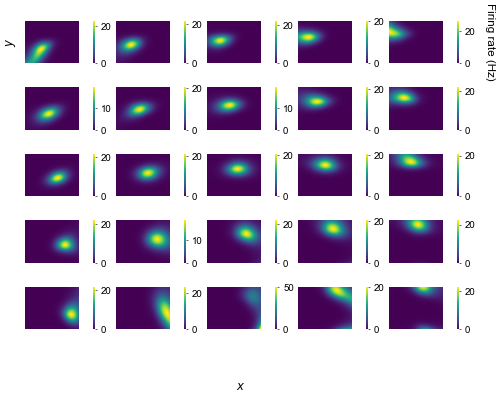

In [25]:
# show fits
grid_size = (50, 40)
grid_shape = [[left_x, right_x], [bottom_y, top_y]]

show_neurons = np.arange(25)

fig = plt.figure(figsize=(8, 6))
nrows = 5
ncols = 5
axes = [ fig.add_subplot(nrows, ncols, r * ncols + c + 1) for r in range(0, nrows) for c in range(0, ncols) ]

for m, neuron in enumerate(show_neurons):
    
    def func(pos):
        prevshape = pos.shape[1:]
        x = pos[0].flatten()
        y = pos[1].flatten()
        covariates = np.array([x, y])
        covariates = np.linalg.inv(W_) @ (covariates/scale_[:, None] - bias_[:, None])
        return gp_lvm.eval_rate(covariates, [neuron])[0].reshape(*prevshape)

    if neuron == 4:
        #cbar = True
        ticktitle='Firing rate (Hz)'
    else:
        #cbar = False
        ticktitle=''
        
    _, field = utils.plot.compute_mesh(grid_size, grid_shape, func)
    #grid_shape = [[-2., 2.], [-2., 2.]]
    im = utils.plot.visualize_field((fig, axes[m]), field, grid_shape, ticktitle=ticktitle)
    if m == 0:
        ylabel=r'$y$'
    else:
        ylabel=None
    utils.plot.decorate_ax(axes[m], ylabel=ylabel, spines=[False, False, False, False])
    #xlim=[left_x, right_x], ylim=[bottom_y, top_y],

fig.text(0.51, 0.0, r'$x$', ha='center', va='center', fontsize=12)

fig.subplots_adjust(hspace=0.3, wspace=0.3)


plt.show()